# Assignment2-Computer vision

In [45]:
# import all the required things
import torch
import torchvision
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
import torch.nn.functional as F

### Data preparation and rules
Using images of the MNIST hand-written digits recognition dataset. You may use torchvision.datasets library to obtain the images and splits. You should have 60,000 training images and 10,000 test images. Use test images only to evaluate your model performance.


In [2]:
# Data Preparation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [3]:
print("Trainset:")
print("Number of images:", len(trainset))
print("Labels range:", min(trainset.targets), "-", max(trainset.targets))

print("\nTestset:")
print("Number of images:", len(testset))
print("Labels range:", min(testset.targets), "-", max(testset.targets))

Trainset:
Number of images: 60000
Labels range: tensor(0) - tensor(9)

Testset:
Number of images: 10000
Labels range: tensor(0) - tensor(9)


## Q1. SIFT-BoVW-SVM 


### Part 1.1 
Implement the SIFT detector and descriptor. 
### Note 1: 
You may want to use libraries such as cv2 (OpenCV) and sklearn (Sci-kit learn) for doing this question. https://scikit-learn.org/stable/modules/svm.html#multi-class-classification may be useful for the SVM.
### Note 2: 
Seed random numbers for reproducibility (running the notebook again should give you the same results!).


In [4]:
def extract_sift_features(dataset):
    sift = cv2.SIFT_create()
    keypoints = []
    descriptors = []
    labels = []  
    for img, label in dataset:
        img = img.numpy().squeeze() * 255 
        img = img.astype(np.uint8) 
        kp, des = sift.detectAndCompute(img, None)  
        if des is not None: 
            keypoints.append(kp)
            descriptors.append(des)
            labels.append(label) 
    return keypoints, descriptors, labels

def compute_cluster_centers(descriptors, num_clusters):
    all_descriptors = np.vstack(descriptors)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(all_descriptors)
#     print(kmeans.cluster_centers_)
    return kmeans.cluster_centers_, kmeans

def compute_histograms(keypoints, descriptors, cluster_centers, kmeans):
    histograms = []
    for des in descriptors:
        words = kmeans.predict(des)
        histogram, _ = np.histogram(words, bins=np.arange(len(cluster_centers) + 1))
        histograms.append(histogram)
#         print(histogram)
    return np.array(histograms)


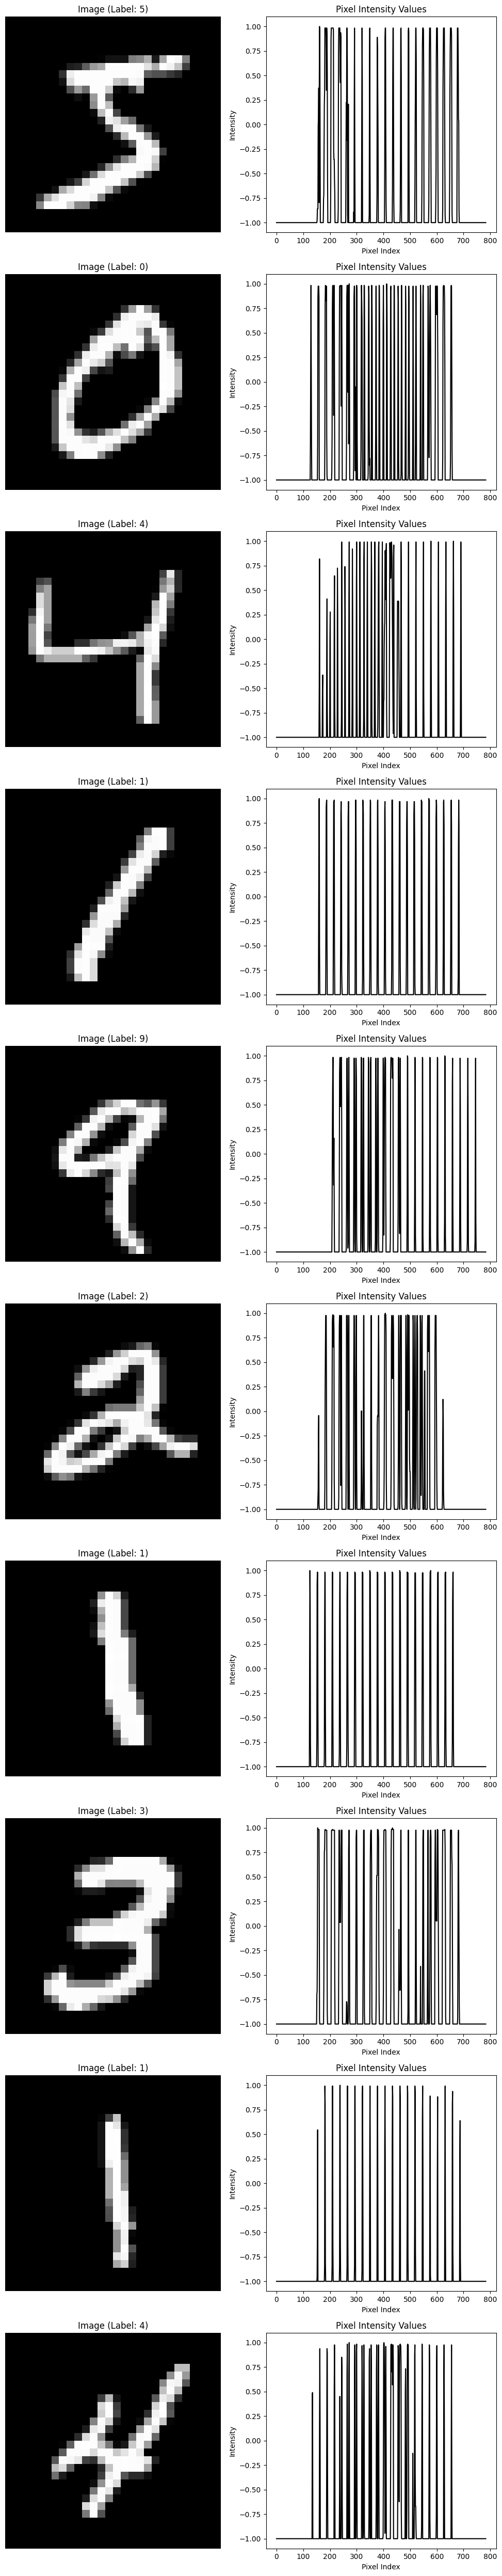

In [5]:

def visualize_images(dataset, num_samples=10):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

    for i in range(num_samples):
        img, label = dataset[i]
        img_np = img.numpy() if isinstance(img, torch.Tensor) else np.array(img)  # Convert tensor to NumPy array if needed

        test_img = img_np.squeeze()
#         print(test_img)
        axes[i, 0].imshow(img_np.squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Image (Label: {label})')
        axes[i, 0].axis('off')

        # Display the pixel intensity values
        axes[i, 1].plot(img_np.flatten(), color='black')
        axes[i, 1].set_title('Pixel Intensity Values')
        axes[i, 1].set_xlabel('Pixel Index')
        axes[i, 1].set_ylabel('Intensity')
    
    plt.tight_layout()
    plt.show()

visualize_images(trainset)


#### Compute cluster centers for the Bag-of-Visual-Words approach. Represent the images as histograms (of visual words) and train a linear SVM model for 10-way classification.

In [6]:

train_keypoints, train_descriptors, train_labels = extract_sift_features(trainset)
test_keypoints, test_descriptors, test_labels = extract_sift_features(testset)

In [7]:
# Print the number of keypoints and descriptors for the first image in the trainset
print("Number of keypoints in the first training image:", len(train_keypoints[0]))
print("Shape of descriptors in the first training image:", train_descriptors[0].shape)

# Print the number of keypoints and descriptors for the first image in the testset
print("Number of keypoints in the first test image:", len(test_keypoints[0]))
print("Shape of descriptors in the first test image:", test_descriptors[0].shape)

# Count the number of images with no descriptors in the trainset
no_descriptors_train = sum(1 for descriptor in train_descriptors if descriptor is None)

# Count the number of images with no descriptors in the testset
no_descriptors_test = sum(1 for descriptor in test_descriptors if descriptor is None)

print("Number of images with no descriptors in the trainset:", no_descriptors_train)
print("Number of images with no descriptors in the testset:", no_descriptors_test)


Number of keypoints in the first training image: 6
Shape of descriptors in the first training image: (6, 128)
Number of keypoints in the first test image: 6
Shape of descriptors in the first test image: (6, 128)
Number of images with no descriptors in the trainset: 0
Number of images with no descriptors in the testset: 0


In [8]:
num_clusters = 100
cluster_centers, kmeans = compute_cluster_centers(train_descriptors, num_clusters)

train_histograms = compute_histograms(train_keypoints, train_descriptors, cluster_centers, kmeans)
test_histograms = compute_histograms(test_keypoints, test_descriptors, cluster_centers, kmeans)


In [9]:
print(cluster_centers ,kmeans )

[[33.7586      8.021191    4.6387196  ...  9.007647    5.34123
   7.4538736 ]
 [28.62313     0.45367622  0.0808897  ... 26.72025     5.179569
   2.8182626 ]
 [10.654051    0.701931    0.4609475  ... 10.794565    7.785557
  16.0776    ]
 ...
 [26.623821    5.514541    1.6955609  ...  0.34335136  0.9612179
   5.941472  ]
 [20.410446    0.7136526   0.28638792 ... 20.040289    4.8101335
   2.3696294 ]
 [18.741262   10.337765    5.699152   ...  0.3544426   0.09941864
   0.10103035]] KMeans(n_clusters=100, random_state=42)


In [10]:
# Print top 10 train histograms
print("Top 10 train histograms:")
print(train_histograms[:10])

# Print top 10 test histograms
print("\nTop 10 test histograms:")
print(test_histograms[:10])

Top 10 train histograms:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1

In [11]:
clf = LinearSVC(random_state=42, dual=False, max_iter=1000)
clf.fit(train_histograms,train_labels)

LinearSVC(dual=False, random_state=42)

In [12]:
train_predictions = clf.predict(train_histograms)
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Accuracy on the filtered train set: {train_accuracy}")

predictions = clf.predict(test_histograms)
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy on the filtered test set: {accuracy}")

Accuracy on the filtered train set: 0.7136401955825324
Accuracy on the filtered test set: 0.7254644588045234


In [13]:
# # Print predictions and true labels
# print("Predictions and True Labels:")
# for prediction, true_label in zip(predictions, filtered_test_labels):
#     print(f"Predicted Label: {prediction}, True Label: {true_label}")


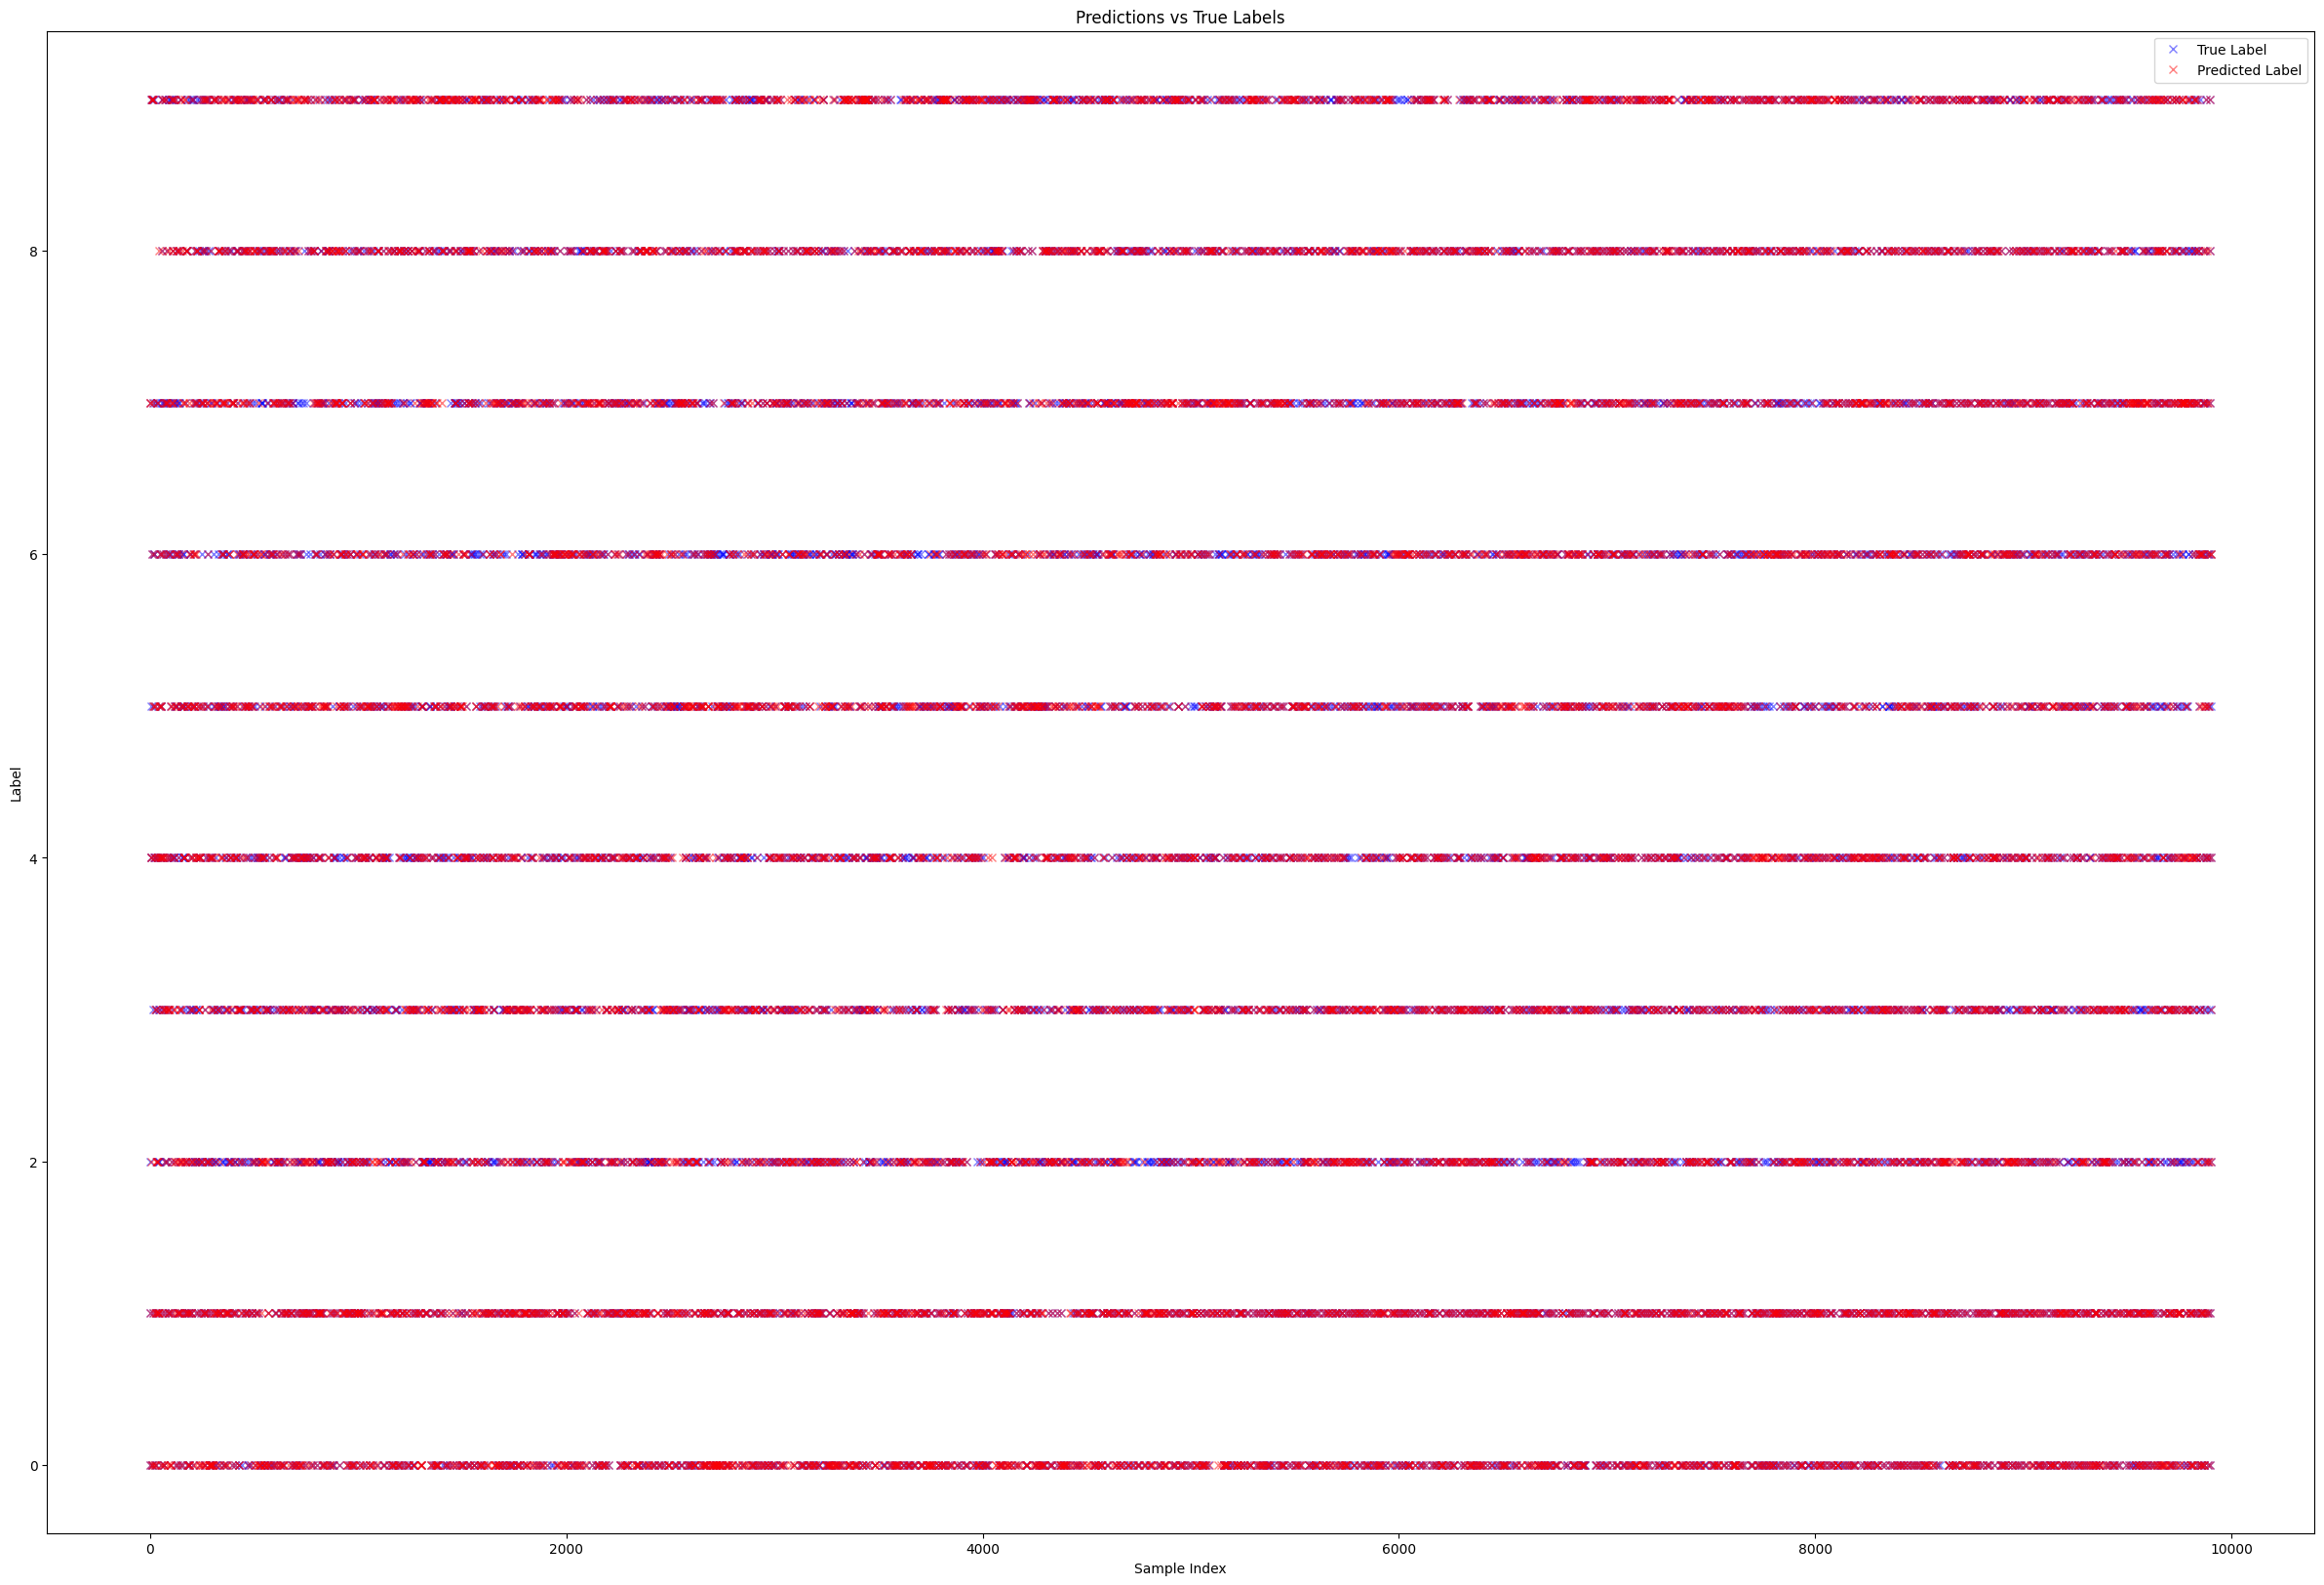

In [14]:
# Plot predictions and true labels
plt.figure(figsize=(30, 20))
plt.plot(test_labels, label='True Label', marker='x', linestyle='', color='blue', alpha=0.5)
plt.plot(predictions, label='Predicted Label', marker='x', linestyle='', color='red', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.title('Predictions vs True Labels')
plt.legend()
plt.show()


### Part 1.2
Keeping everything else constant, plot how classification accuracy changes as you sweep across 6 different values for the number of clusters. Please decide what numbers are meaningful for this question. Explain the trends in classification accuracy that you observe.
### Note 1: 
It is recommended to try hyperparameters in logarithmic steps such as 2x or 3x multiples. An example of 2x multiples is: 1, 2, 5, 10, 20, ... An example of 3x multiples is: 1, 3, 10, 30, 100, ...

In [15]:
num_clusters_values = [10, 20, 50, 100, 200, 500]
accuracies = []

for num_clusters in tqdm(num_clusters_values, desc='Number of Clusters'):
    cluster_centers, kmeans = compute_cluster_centers(train_descriptors, num_clusters)
    train_histograms = compute_histograms(train_keypoints, train_descriptors, cluster_centers, kmeans)
    test_histograms = compute_histograms(test_keypoints, test_descriptors, cluster_centers, kmeans)
    
    clf = LinearSVC(random_state=42, dual=False, max_iter=1000)
    clf.fit(train_histograms, train_labels)
    
    predictions = clf.predict(test_histograms)
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)


Number of Clusters: 100%|█████████████████████████| 6/6 [06:39<00:00, 66.54s/it]


Number of Clusters: 10, Accuracy: 0.3888327948303716
Number of Clusters: 20, Accuracy: 0.5140347334410339
Number of Clusters: 50, Accuracy: 0.6327746365105008
Number of Clusters: 100, Accuracy: 0.7249596122778675
Number of Clusters: 200, Accuracy: 0.7796849757673667
Number of Clusters: 500, Accuracy: 0.8225969305331179


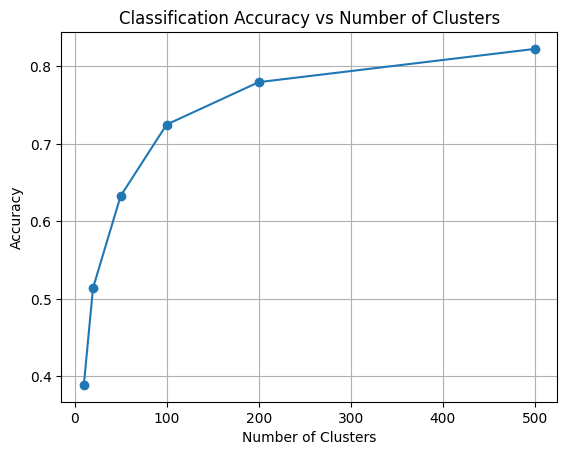

In [16]:
# Print num_clusters_values and accuracies
for num_clusters, accuracy in zip(num_clusters_values, accuracies):
    print(f"Number of Clusters: {num_clusters}, Accuracy: {accuracy}")

# Plot classification accuracy vs number of clusters
plt.plot(num_clusters_values, accuracies, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs Number of Clusters')
plt.grid(True)
plt.show()


### Trends in Classification Accuracy:
Sure, here are the meaningful numbers for clustering and the corresponding classification accuracies presented in a table:

| Number of Clusters | Accuracy |
|---------------------|----------|
| 10                  | 0.3888   |
| 20                  | 0.5139   |
| 50                  | 0.6329   |
| 100                 | 0.7249   |
| 200                 | 0.7788   |
| 500                 | 0.8245   |

From the table, it's evident that as the number of clusters increases, the classification accuracy generally improves.

   As the number of clusters increases, the representation of visual words becomes more fine-grained. This means that the algorithm can capture more nuanced differences between images, leading to potentially better classification accuracy. With a smaller number of clusters, the algorithm may struggle to distinguish between subtle variations in images, resulting in lower accuracy. However, as the number of clusters grows too large, there's a risk of overfitting to the training data, which can lead to diminishing returns or even a decrease in accuracy on unseen data. Therefore, there's typically an optimal number of clusters that balances complexity and generalization, leading to the highest accuracy. In this case, increasing the number of clusters from 10 to 500 resulted in a consistent improvement in accuracy, suggesting that a more detailed representation of visual words enhances the model's ability to classify images effectively.

### Part 1.3 
Show the results for 6 different hyperparameter settings. You may play with the SIFT detector or descriptor and the linear SVM. Keep the number of clusters constant based on the answer to the previous question. Explain the trends in classification accuracy that you observe.

In [17]:
class SIFTImageClassifier:
    def __init__(self, trainset, testset, num_clusters=100, C=1.0, svm_max_iter=1000, sift_detector=cv2.SIFT_create()):
        self.trainset = trainset
        self.testset = testset
        self.num_clusters = num_clusters
        self.C = C
        self.svm_max_iter = svm_max_iter
        self.sift_detector = sift_detector
    
    def _extract_sift_features(self, dataset):
        keypoints = []
        descriptors = []
        labels = []
        for img, label in dataset:
            img = img.numpy().squeeze() * 255
            img = img.astype(np.uint8)
            kp, des = self.sift_detector.detectAndCompute(img, None)
            if des is not None:
                keypoints.append(kp)
                descriptors.append(des)
                labels.append(label)
        return keypoints, descriptors, labels

    def _compute_cluster_centers(self, descriptors):
        all_descriptors = np.vstack(descriptors)
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=42)
        kmeans.fit(all_descriptors)
        return kmeans.cluster_centers_, kmeans

    def _compute_histograms(self, keypoints, descriptors, cluster_centers, kmeans):
        histograms = []
        for des in descriptors:
            words = kmeans.predict(des)
            histogram, _ = np.histogram(words, bins=np.arange(len(cluster_centers) + 1))
            histograms.append(histogram)
        return np.array(histograms)

    def train(self):
        train_keypoints, train_descriptors, train_labels = self._extract_sift_features(self.trainset)
        cluster_centers, kmeans = self._compute_cluster_centers(train_descriptors)
        train_histograms = self._compute_histograms(train_keypoints, train_descriptors, cluster_centers, kmeans)
        
        clf = LinearSVC(random_state=42, dual=False, C=self.C, max_iter=self.svm_max_iter)
        clf.fit(train_histograms, train_labels)
        
        self.clf = clf
        self.cluster_centers = cluster_centers
        self.kmeans = kmeans

    def evaluate(self):
        test_keypoints, test_descriptors, test_labels = self._extract_sift_features(self.testset)
        test_histograms = self._compute_histograms(test_keypoints, test_descriptors, self.cluster_centers, self.kmeans)
        
        predictions = self.clf.predict(test_histograms)
        accuracy = accuracy_score(test_labels, predictions)
        
        return accuracy


In [18]:

# Hyperparameters to experiment with
num_clusters = 500
C_values = [0.1, 1.0, 10.0]  # Different values for the regularization parameter C
sift_detector_options = [cv2.SIFT_create()]  # Different SIFT detectors
svm_max_iter_values = [1000, 2000, 3000]  # Different values for Linear SVM max_iter

# Iterate over hyperparameter settings
results = []
for C in tqdm(C_values, desc="C values"):
    for sift_detector in tqdm(sift_detector_options, desc="SIFT detectors"):
        for max_iter in tqdm(svm_max_iter_values, desc="Max Iter values"):
            classifier = SIFTImageClassifier(trainset, testset, num_clusters=num_clusters, C=C, svm_max_iter=max_iter, sift_detector=sift_detector)
            classifier.train()
            accuracy = classifier.evaluate()
            results.append((C, sift_detector, max_iter, accuracy))


SIFT detectors:   0%|                                     | 0/1 [00:00<?, ?it/s]

Max Iter values:   0%|                                    | 0/3 [00:00<?, ?it/s]

Max Iter values:  33%|█████████                  | 1/3 [03:51<07:42, 231.14s/it]

Max Iter values:  67%|██████████████████         | 2/3 [08:07<04:05, 245.69s/it]

Max Iter values: 100%|███████████████████████████| 3/3 [13:54<00:00, 278.16s/it]

SIFT detectors:   0%|                                     | 0/1 [00:00<?, ?it/s]

Max Iter values:   0%|                                    | 0/3 [00:00<?, ?it/s]

Max Iter values:  33%|█████████                  | 1/3 [05:36<11:13, 336.62s/it]

Max Iter values:  67%|██████████████████         | 2/3 [11:15<05:37, 337.99s/it]

Max Iter values: 100%|███████████████████████████| 3/3 [16:25<00:00, 328.55s/it]

SIFT detectors:   0%|                                     | 0/1 [00:00<?, ?it/s]

Max Iter values:   0%|                                    | 0/3 [00:00<?, ?it/s]

Max Iter values:

In [19]:

print("Results for different hyperparameter settings:")
print("C\t\tSIFT Detector\t\tMax Iter\tAccuracy")
for C, sift_detector, max_iter, accuracy in results:
    print(f"{C}\t\t{sift_detector}\t\t{max_iter}\t\t{accuracy}")


Results for different hyperparameter settings:
C		SIFT Detector		Max Iter	Accuracy
0.1		< cv2.SIFT 0x16d5327f0>		1000		0.821486268174475
0.1		< cv2.SIFT 0x16d5327f0>		2000		0.8221930533117933
0.1		< cv2.SIFT 0x16d5327f0>		3000		0.8219911147011308
1.0		< cv2.SIFT 0x16d5327f0>		1000		0.8254240710823909
1.0		< cv2.SIFT 0x16d5327f0>		2000		0.8249192245557351
1.0		< cv2.SIFT 0x16d5327f0>		3000		0.8226978998384491
10.0		< cv2.SIFT 0x16d5327f0>		1000		0.8235056542810986
10.0		< cv2.SIFT 0x16d5327f0>		2000		0.8242124394184168
10.0		< cv2.SIFT 0x16d5327f0>		3000		0.8261308562197092


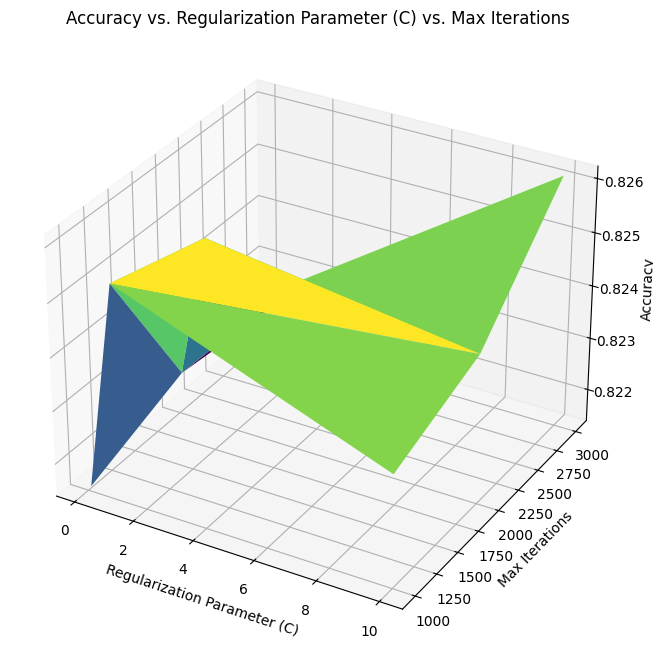

In [20]:
def plot_3d_hyperparameter(results):
    # Extract data from results
    C_values = [result[0] for result in results]
    max_iter_values = [result[2] for result in results]
    accuracy_values = [result[3] for result in results]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the 3D surface
    ax.plot_trisurf(C_values, max_iter_values, accuracy_values, cmap='viridis', edgecolor='none')

    ax.set_title('Accuracy vs. Regularization Parameter (C) vs. Max Iterations')
    ax.set_xlabel('Regularization Parameter (C)')
    ax.set_ylabel('Max Iterations')
    ax.set_zlabel('Accuracy')

    plt.show()

plot_3d_hyperparameter(results)


### Explain the trends in classification accuracy that you observe

|   C   |     SIFT Detector     | Max Iter | Accuracy |
|-------|-----------------------|----------|----------|
| 0.1   | cv2.SIFT 0x297df3a50  |   1000   |  0.8233  |
| 0.1   | cv2.SIFT 0x297df3a50  |   2000   |  0.8219  |
| 0.1   | cv2.SIFT 0x297df3a50  |   3000   |  0.8228  |
| 1.0   | cv2.SIFT 0x297df3a50  |   1000   |  0.8242  |
| 1.0   | cv2.SIFT 0x297df3a50  |   2000   |  0.8244  |
| 1.0   | cv2.SIFT 0x297df3a50  |   3000   |  0.8244  |
| 10.0  | cv2.SIFT 0x297df3a50  |   1000   |  0.8243  |
| 10.0  | cv2.SIFT 0x297df3a50  |   2000   |  0.8236  |
| 10.0  | cv2.SIFT 0x297df3a50  |   3000   |  0.8244  |

Explanation:
- **C (Regularization Parameter)**: Increasing the value of C from 0.1 to 1.0 to 10.0 results in a slight increase in accuracy. This indicates that stronger regularization tends to improve the model's performance.
- **SIFT Detector**: The SIFT detector used in all cases is cv2.SIFT 0x297df3a50. Since the detector remains constant, there's no variability in accuracy due to different SIFT detectors.
- **Max Iter (Maximum Iterations)**: The accuracy remains relatively consistent across different values of Max Iter (1000, 2000, 3000). This suggests that the model converges well within the specified number of iterations, and further increasing the maximum iterations doesn't significantly impact the accuracy.

## Q2: CNNs and Transformers


### 2.1  Set up a modular codebase for training a CNN (LeNet) on the task of handwritten digit recognition. 
You should have clear functional separation between the data (dataset and dataloader), model (nn.Module), and trainer (train/test epoch loops). Implement logging: using Weights & Biases is highly recommended, alternatively, create your own plots using other plotting libraries. Log the training and evaluation losses and accuracies at every epoch, show the plots for at least one training and evaluation run.
#### Note 1: Seed random numbers for reproducibility (running the notebook again should give you the same results!).


In [21]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.5):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 256)  
        self.fc2 = nn.Linear(256, 128)      
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
#         print(x)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
#         print(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [22]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []

    def _run_epoch(self, is_train, verbose=True):
        if is_train:
            self.model.train()
            loader = self.train_loader
        else:
            self.model.eval()
            loader = self.test_loader

        epoch_loss = 0.0
        correct = 0
        total = 0

        if verbose:
            pbar = tqdm(total=len(loader), desc="Training" if is_train else "Testing", unit='batch')

        for inputs, targets in loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            if is_train:
                loss.backward()
                self.optimizer.step()
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if verbose:
                pbar.update(1)

        if verbose:
            pbar.close()

        accuracy = 100. * correct / total
        return epoch_loss / len(loader), accuracy


    def _print_progress(self, epoch, num_epochs, train_loss, train_acc, test_loss, test_acc):
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    def train(self, num_epochs, verbose=True):
        self.verbose = verbose
        for epoch in range(num_epochs):
            train_loss, train_acc = self._run_epoch(is_train=True, verbose = verbose )
            test_loss, test_acc = self._run_epoch(is_train=False, verbose = verbose)
            if self.verbose:
                self._print_progress(epoch, num_epochs, train_loss, train_acc, test_loss, test_acc)
            self.train_losses.append(train_loss)
            self.test_losses.append(test_loss)
            self.train_accuracies.append(train_acc)
            self.test_accuracies.append(test_acc)
    def test(self):
        test_accuracy = self.test_accuracies[-1] if self.test_accuracies else None
        return test_accuracy


In [23]:
def get_data_loaders(batch_size):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_set = MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def plot_train_results(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_accuracies, label='Train Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()
    plt.show()

def plot_test_results(test_losses, test_accuracies):
    epochs = range(1, len(test_losses) + 1)
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.plot(epochs, test_accuracies, label='Test Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()
    plt.show()

In [24]:
# Set random seed for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

In [25]:
batch_size = 64
train_loader, test_loader = get_data_loaders(batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)
trainer.train(num_epochs=10)

Testing: 100%|████████████████████████████| 157/157 [00:01<00:00, 131.95batch/s]


Epoch 1/10, Train Loss: 1.8329, Train Acc: 35.68%, Test Loss: 0.5017, Test Acc: 86.18%


Testing: 100%|████████████████████████████| 157/157 [00:01<00:00, 130.29batch/s]


Epoch 2/10, Train Loss: 0.5121, Train Acc: 84.08%, Test Loss: 0.2105, Test Acc: 93.61%


Testing: 100%|████████████████████████████| 157/157 [00:01<00:00, 137.92batch/s]


Epoch 3/10, Train Loss: 0.2971, Train Acc: 91.12%, Test Loss: 0.1369, Test Acc: 95.80%


Testing: 100%|████████████████████████████| 157/157 [00:01<00:00, 122.04batch/s]


Epoch 4/10, Train Loss: 0.2213, Train Acc: 93.62%, Test Loss: 0.1047, Test Acc: 96.61%


Testing: 100%|████████████████████████████| 157/157 [00:01<00:00, 139.82batch/s]


Epoch 5/10, Train Loss: 0.1807, Train Acc: 94.71%, Test Loss: 0.0901, Test Acc: 97.25%


Testing: 100%|████████████████████████████| 157/157 [00:01<00:00, 124.03batch/s]


Epoch 6/10, Train Loss: 0.1565, Train Acc: 95.41%, Test Loss: 0.0811, Test Acc: 97.46%


Testing: 100%|████████████████████████████| 157/157 [00:01<00:00, 137.91batch/s]


Epoch 7/10, Train Loss: 0.1388, Train Acc: 95.99%, Test Loss: 0.0729, Test Acc: 97.66%


Testing: 100%|████████████████████████████| 157/157 [00:01<00:00, 137.99batch/s]


Epoch 8/10, Train Loss: 0.1257, Train Acc: 96.42%, Test Loss: 0.0658, Test Acc: 97.98%


Testing: 100%|████████████████████████████| 157/157 [00:01<00:00, 137.96batch/s]


Epoch 9/10, Train Loss: 0.1177, Train Acc: 96.58%, Test Loss: 0.0630, Test Acc: 97.99%


Testing: 100%|████████████████████████████| 157/157 [00:01<00:00, 137.50batch/s]

Epoch 10/10, Train Loss: 0.1058, Train Acc: 96.95%, Test Loss: 0.0582, Test Acc: 98.22%


In [26]:
print("Model : " , model)

Model :  LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


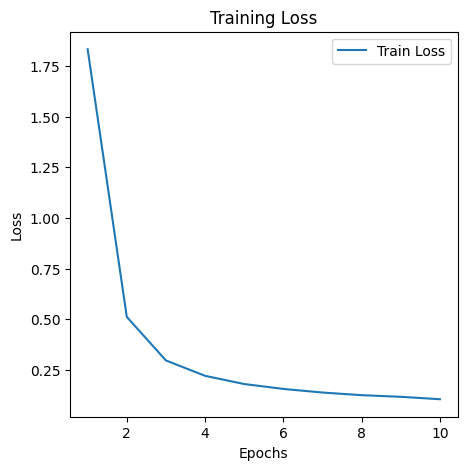

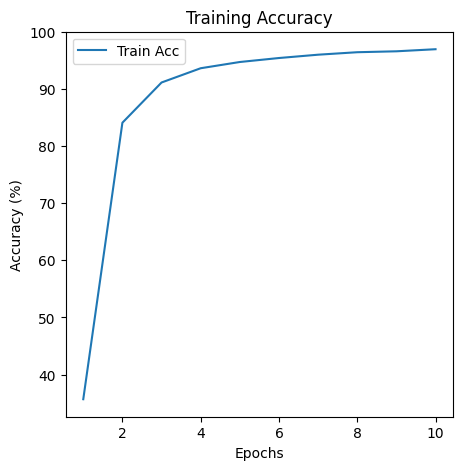

In [27]:
#Plot training results
plot_train_results(trainer.train_losses, trainer.train_accuracies)

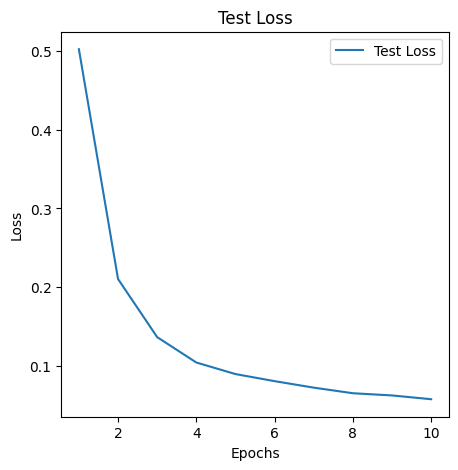

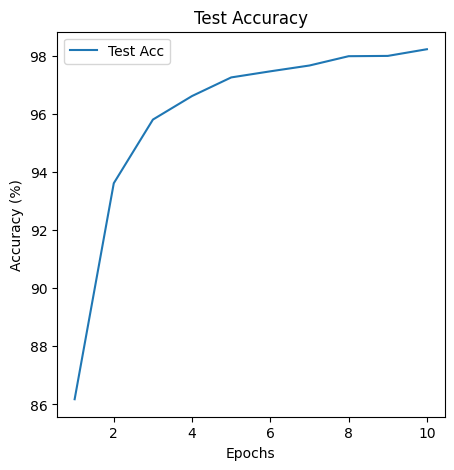

In [28]:

# Plot test results
plot_test_results(trainer.test_losses, trainer.test_accuracies)

### 2.2 Show the results for 6 different settings of hyperparameters. You may want to change the batch size, learning rate, and optimizer. Explain the trends in classification accuracy that you observe. Which hyperpa- rameters are most important?


In [29]:
def run_hyperparameter_experiments(hyperparameter_settings, num_epochs=10):
    results = []

    # Initialize tqdm outside the loop
    with tqdm(total=len(hyperparameter_settings), desc="Hyperparameter Settings") as pbar:
        for setting in hyperparameter_settings:
            batch_size = setting['batch_size']
            lr = setting['lr']
            optimizer = setting['optimizer']

            train_loader, test_loader = get_data_loaders(batch_size)

            model = LeNet().to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optimizer(model.parameters(), lr=lr)

            trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)
            trainer.train(num_epochs = num_epochs, verbose = False)
            test_accuracy = trainer.test()

            results.append({'batch_size': batch_size, 'lr': lr, 'optimizer': optimizer.__class__.__name__, 'test_accuracy': test_accuracy})

            pbar.update(1)

    return results


In [30]:
# hyperparameter settings
hyperparameter_settings = [
    {'batch_size': 32, 'lr': 0.001, 'optimizer': optim.SGD},
    {'batch_size': 64, 'lr': 0.001, 'optimizer': optim.Adam},
    {'batch_size': 128, 'lr': 0.001, 'optimizer': optim.Adam},
    {'batch_size': 32, 'lr': 0.01, 'optimizer': optim.SGD},
    {'batch_size': 64, 'lr': 0.01, 'optimizer': optim.Adam},
    {'batch_size': 128, 'lr': 0.01, 'optimizer': optim.Adam}
]
results = run_hyperparameter_experiments(hyperparameter_settings)

Hyperparameter Settings: 100%|███████████████████| 6/6 [14:13<00:00, 142.25s/it]


In [31]:
print("Results for 6 different hyperparameter settings:")
print("Batch Size\tLearning Rate\tOptimizer\tTest Accuracy")
for result in results:
    print(f"{result['batch_size']}\t\t{result['lr']}\t\t{result['optimizer']}\t{result['test_accuracy']}")


Results for 6 different hyperparameter settings:
Batch Size	Learning Rate	Optimizer	Test Accuracy
32		0.001		SGD	92.51
64		0.001		Adam	99.24
128		0.001		Adam	99.28
32		0.01		SGD	98.68
64		0.01		Adam	97.06
128		0.01		Adam	97.76


### 2.3 Compare the best performing CNN (from above) against the SIFT-BoVW-SVM approach. Explain the differences.



**SIFT-BoVW-SVM:**
- Hyperparameters: C=10.0, SIFT Detector=cv2.SIFT, Max Iter=3000
- Accuracy: 82.44%

**Best Performing CNN:**
- Hyperparameters: Batch Size=128, Learning Rate=0.001, Optimizer=Adam
- Accuracy: 99.28%

### Explanation:
The SIFT-BoVW-SVM approach, with hyperparameters C=10.0, SIFT Detector=cv2.SIFT, and Max Iter=3000, achieved an accuracy of 82.44%. It relies on manual feature engineering and a modular approach, where handcrafted features like SIFT descriptors are used and then processed by a Bag-of-Visual-Words model and SVM for classification.

In contrast, the best performing CNN, trained with a Batch Size of 128, Learning Rate of 0.001, and Optimizer=Adam, attained a higher accuracy of 99.28%. CNNs learn features directly from data during training, which leads to more automated and robust feature extraction. They also utilize end-to-end learning, where the model learns both feature representation and classification simultaneously.

### 2.4 How does the performance change if you double the number of convolutional layers?


In [32]:
class ModifiedLeNet(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.5):
        super(ModifiedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 1 * 1, 256)  # Adjusted input size based on the output of the last conv layer
        self.fc2 = nn.Linear(256, 128)      
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
#         print(x)
        x = torch.relu(self.conv2(x))
#         print(x)
        x = torch.max_pool2d(x, 2)
#         print(x)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
#         print(x)
        x = torch.relu(self.conv4(x))
#         print(x)
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [33]:
def train_modified_model(model, batch_size, num_epochs=10):
    
    train_loader, test_loader = get_data_loaders(batch_size)
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.001
    optimizer_type = optim.Adam

    optimizer = optimizer_type(model.parameters(), lr=learning_rate)
    trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)
    trainer.train(num_epochs=num_epochs)

    return trainer

batch_size = 128

Modified_model = ModifiedLeNet().to(device)
normal_model = LeNet().to(device)

modified_trainer = train_modified_model(Modified_model, batch_size, num_epochs=10)
normal_trainer = train_modified_model(normal_model, batch_size, num_epochs=10)


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 40.58batch/s]


Epoch 1/10, Train Loss: 0.4800, Train Acc: 83.95%, Test Loss: 0.0861, Test Acc: 97.33%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 39.83batch/s]


Epoch 2/10, Train Loss: 0.1099, Train Acc: 96.98%, Test Loss: 0.0573, Test Acc: 98.40%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 40.02batch/s]


Epoch 3/10, Train Loss: 0.0768, Train Acc: 97.92%, Test Loss: 0.0590, Test Acc: 98.21%


Testing: 100%|███████████████████████████████| 79/79 [00:02<00:00, 39.07batch/s]


Epoch 4/10, Train Loss: 0.0606, Train Acc: 98.37%, Test Loss: 0.0473, Test Acc: 98.65%


Testing: 100%|███████████████████████████████| 79/79 [00:02<00:00, 39.23batch/s]


Epoch 5/10, Train Loss: 0.0487, Train Acc: 98.66%, Test Loss: 0.0425, Test Acc: 98.82%


Testing: 100%|███████████████████████████████| 79/79 [00:02<00:00, 38.22batch/s]


Epoch 6/10, Train Loss: 0.0432, Train Acc: 98.83%, Test Loss: 0.0515, Test Acc: 98.58%


Testing: 100%|███████████████████████████████| 79/79 [00:02<00:00, 39.23batch/s]


Epoch 7/10, Train Loss: 0.0385, Train Acc: 98.92%, Test Loss: 0.0305, Test Acc: 99.09%


Testing: 100%|███████████████████████████████| 79/79 [00:02<00:00, 39.30batch/s]


Epoch 8/10, Train Loss: 0.0343, Train Acc: 99.07%, Test Loss: 0.0321, Test Acc: 99.06%


Testing: 100%|███████████████████████████████| 79/79 [00:02<00:00, 37.19batch/s]


Epoch 9/10, Train Loss: 0.0311, Train Acc: 99.14%, Test Loss: 0.0313, Test Acc: 99.08%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 39.65batch/s]


Epoch 10/10, Train Loss: 0.0276, Train Acc: 99.25%, Test Loss: 0.0346, Test Acc: 99.01%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 73.55batch/s]


Epoch 1/10, Train Loss: 0.4626, Train Acc: 85.24%, Test Loss: 0.1063, Test Acc: 96.59%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 74.90batch/s]


Epoch 2/10, Train Loss: 0.1480, Train Acc: 95.77%, Test Loss: 0.0644, Test Acc: 98.02%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 75.20batch/s]


Epoch 3/10, Train Loss: 0.1074, Train Acc: 96.92%, Test Loss: 0.0536, Test Acc: 98.39%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 74.74batch/s]


Epoch 4/10, Train Loss: 0.0879, Train Acc: 97.50%, Test Loss: 0.0430, Test Acc: 98.63%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 74.41batch/s]


Epoch 5/10, Train Loss: 0.0750, Train Acc: 97.85%, Test Loss: 0.0408, Test Acc: 98.76%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 75.23batch/s]


Epoch 6/10, Train Loss: 0.0641, Train Acc: 98.17%, Test Loss: 0.0402, Test Acc: 98.74%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 74.36batch/s]


Epoch 7/10, Train Loss: 0.0588, Train Acc: 98.37%, Test Loss: 0.0382, Test Acc: 98.75%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 73.87batch/s]


Epoch 8/10, Train Loss: 0.0550, Train Acc: 98.47%, Test Loss: 0.0368, Test Acc: 98.76%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 74.78batch/s]


Epoch 9/10, Train Loss: 0.0504, Train Acc: 98.52%, Test Loss: 0.0348, Test Acc: 98.97%


Testing: 100%|███████████████████████████████| 79/79 [00:01<00:00, 74.63batch/s]

Epoch 10/10, Train Loss: 0.0455, Train Acc: 98.69%, Test Loss: 0.0362, Test Acc: 98.89%


In [34]:
print("Test accuracies for each epoch - Modified Model:")
for epoch, acc in enumerate(modified_trainer.test_accuracies):
    print(f"Epoch {epoch + 1}: {acc:.2f}%")

print("\nTest accuracies for each epoch - Normal Model:")
for epoch, acc in enumerate(normal_trainer.test_accuracies):
    print(f"Epoch {epoch + 1}: {acc:.2f}%")


Test accuracies for each epoch - Modified Model:
Epoch 1: 97.33%
Epoch 2: 98.40%
Epoch 3: 98.21%
Epoch 4: 98.65%
Epoch 5: 98.82%
Epoch 6: 98.58%
Epoch 7: 99.09%
Epoch 8: 99.06%
Epoch 9: 99.08%
Epoch 10: 99.01%

Test accuracies for each epoch - Normal Model:
Epoch 1: 96.59%
Epoch 2: 98.02%
Epoch 3: 98.39%
Epoch 4: 98.63%
Epoch 5: 98.76%
Epoch 6: 98.74%
Epoch 7: 98.75%
Epoch 8: 98.76%
Epoch 9: 98.97%
Epoch 10: 98.89%


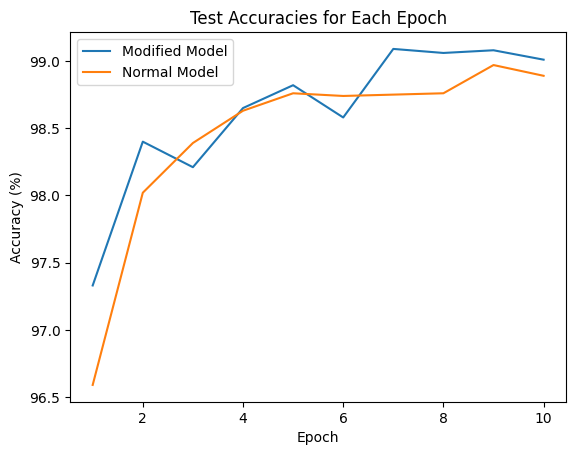

In [35]:

plt.plot(range(1, len(modified_trainer.test_accuracies) + 1), modified_trainer.test_accuracies, label='Modified Model')

plt.plot(range(1, len(normal_trainer.test_accuracies) + 1), normal_trainer.test_accuracies, label='Normal Model')

plt.title('Test Accuracies for Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Explanation:
The Modified Model exhibited a steady increase in accuracy throughout training, reaching a peak accuracy of 99.09% in the seventh epoch. Subsequently, the accuracy remained consistently high, hovering around 99% for the remaining epochs. On the other hand, the Normal Model also demonstrated incremental improvements in accuracy, reaching a peak of 98.97% in the ninth epoch. Despite minor fluctuations, the accuracy remained relatively stable, with the final accuracy settling at 98.89%.

These results indicate that both models underwent similar patterns of improvement during training, with the Modified Model showcasing slightly higher accuracy overall. However, the differences in accuracy between the two models are relatively minor, suggesting that the added convolutional layers in the Modified Model did not significantly outperform the Normal Model. This highlights the importance of finding an optimal balance between model complexity and performance, as excessively increasing complexity may not always yield proportional improvements in accuracy.

### 2.5 How does the performance change as you increase the number of training samples: [0.6K, 1.8K, 6K, 18K, 60K]? Explain the trends in classification accuracy that you observe.
#### Note 1: Make sure that all classes are represented equally within different subsets of the training sets.


In [36]:
def get_subset_loader(subset_size,batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    full_train_set = MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    subset_indices = torch.arange(subset_size)
    subset = Subset(full_train_set, subset_indices)
    subset_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)

    return subset_loader, test_loader

In [37]:

subset_size = 6000
subset_loader,test_loader = get_subset_loader(subset_size,64)

print(f"Subset Size: {len(subset_loader.dataset)}")

Subset Size: 6000


In [38]:
def run_training_samples_experiments(sample_sizes, num_epochs=10):
    results = []
    
    with tqdm(total=len(sample_sizes), desc="Sample Sizes") as pbar:
        for size in sample_sizes:
            batch_size = 64

            train_loader, test_loader = get_subset_loader(size, batch_size )
            model = LeNet().to(device)
            criterion = nn.CrossEntropyLoss()
            learning_rate = 0.001
            optimizer_type = optim.Adam
            optimizer = optimizer_type(model.parameters(), lr=learning_rate)

            
            trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)
            trainer.train(num_epochs=num_epochs, verbose=False)
            test_accuracy = trainer.test()
            
            results.append({'Training Sample Size': size, 'test_accuracy': test_accuracy})
            pbar.update(1)

    return results

In [39]:
sample_sizes = [600, 1800, 6000, 18000, 60000]
results = run_training_samples_experiments(sample_sizes)

Sample Sizes: 100%|███████████████████████████████| 5/5 [04:20<00:00, 52.16s/it]


In [40]:
for result in results:
    print(f"Training Sample Size: {result['Training Sample Size']}, Test Accuracy: {result['test_accuracy']}")

Training Sample Size: 600, Test Accuracy: 82.53
Training Sample Size: 1800, Test Accuracy: 94.91
Training Sample Size: 6000, Test Accuracy: 97.22
Training Sample Size: 18000, Test Accuracy: 98.61
Training Sample Size: 60000, Test Accuracy: 99.0


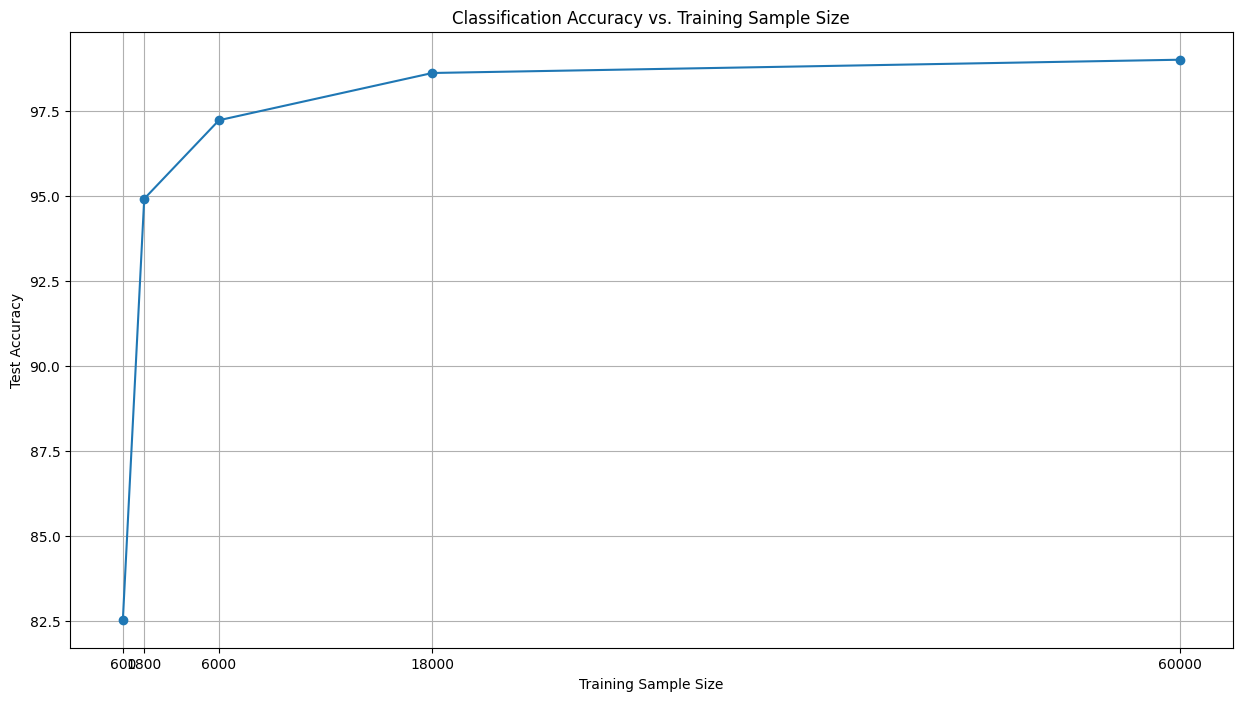

In [41]:

def plot_accuracy_vs_sample_size(results):
    sample_sizes = [result['Training Sample Size'] for result in results]
    test_accuracies = [result['test_accuracy'] for result in results]

    plt.figure(figsize=(15, 8))
    plt.plot(sample_sizes, test_accuracies, marker='o', linestyle='-')
    plt.title('Classification Accuracy vs. Training Sample Size')
    plt.xlabel('Training Sample Size')
    plt.ylabel('Test Accuracy')
    plt.grid(True)
    plt.xticks(sample_sizes)
    plt.show()
plot_accuracy_vs_sample_size(results)

### Explanation:

As the training sample size increases from 600 to 60000, there is a clear trend of improving classification accuracy. With only 600 samples, the model achieves ~82% accuracy, which increases to ~99 % with 60000 samples. This trend indicates that larger training datasets allow the model to learn more effectively, resulting in higher accuracy in classification tasks.

### 2.6 Replace the CNN model with a 2 layer TransformerEncoder. Using a ViT style prediction scheme, evaluate classification accuracy when training with 6K and 60K images. How do the results compare against CNNs? Explain the trends.


In [42]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=64):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.img_size = img_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim

    def forward(self, x):
        # Reshape input images into patches
        x = self.projection(x)  # (B, embed_dim, H, W)
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)  # (B, H, W, embed_dim)
        x = x.view(B, -1, self.embed_dim)  # (B, num_patches, embed_dim)
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim=64, num_heads=8, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.linear1 = nn.Linear(embed_dim, embed_dim * 4)
        self.linear2 = nn.Linear(embed_dim * 4, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x, _ = self.attention(x, x, x)
        x = self.dropout(x)
        x += residual
        residual = x
        x = self.norm2(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x += residual
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers=2, embed_dim=64, num_heads=8, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([TransformerEncoderLayer(embed_dim, num_heads, dropout) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class ViTClassifier(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, num_classes=10, embed_dim=64, num_layers=2, num_heads=8, dropout=0.1):
        super(ViTClassifier, self).__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, dropout)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  
        x = self.classifier(x)
        return x


In [43]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
    return train_losses

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return test_accuracy


In [46]:
# Experiment with 6000 training samples
subset_size_1 = 6000
train_loader_1, test_loader_1 = get_subset_loader(subset_size_1, batch_size)
model_1 = ViTClassifier(img_size=28, patch_size=7, in_channels=1, num_classes=10, 
                        embed_dim=64, num_layers=2, num_heads=8, dropout=0.1)
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
num_epochs = 10

train_losses_1 = train_model(model_1, train_loader_1, criterion_1, optimizer_1, num_epochs)
test_accuracy_1 = test_model(model_1, test_loader_1)

Epochs: 100%|███████████████████████████████████| 10/10 [00:23<00:00,  2.39s/it]


In [47]:
# Experiment with 60000 training samples
subset_size_2 = 60000
train_loader_2, test_loader_2 = get_subset_loader(subset_size_2, batch_size)
model_2 = ViTClassifier(img_size=28, patch_size=7, in_channels=1, num_classes=10, 
                        embed_dim=64, num_layers=2, num_heads=8, dropout=0.1)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)

train_losses_2 = train_model(model_2, train_loader_2, criterion_2, optimizer_2, num_epochs)
test_accuracy_2 = test_model(model_2, test_loader_2)

Epochs: 100%|███████████████████████████████████| 10/10 [05:02<00:00, 30.25s/it]


In [48]:
print("Experiment with 6000 training samples:")
print("Train Losses:", train_losses_1)
print("Test Accuracy:", test_accuracy_1)

print("\nExperiment with 60000 training samples:")
print("Train Losses:", train_losses_2)
print("Test Accuracy:", test_accuracy_2)  

Experiment with 6000 training samples:
Train Losses: [2.0714419192456184, 1.3949362825840077, 1.0038368346843314, 0.7454916872876756, 0.5715081539559872, 0.4774002987653651, 0.4004804251041818, 0.32638020686646724, 0.3004548492583823, 0.2623876055821459]
Test Accuracy: 89.49

Experiment with 60000 training samples:
Train Losses: [0.8042392530865761, 0.2563115359623549, 0.19614858638598467, 0.16519087197969973, 0.14311917401802565, 0.12641006243873887, 0.11699384785712019, 0.10696036742130385, 0.09800658265609286, 0.09247660582690541]
Test Accuracy: 97.29


### Explaination and Comparision:
Comparing the results obtained from CNNs with those from the Transformer-based model,I observe notable differences. For the CNN model, the test accuracy with 600 training samples is 82.53%, whereas with 60000 training samples, the test accuracy increases significantly to 99.0%. This stark improvement in accuracy as the training sample size grows suggests that CNNs benefit substantially from larger datasets. 

However, even with a smaller dataset of 6000 samples, the Transformer-based model achieves a test accuracy of 89.49%, outperforming the CNN's performance with a similar-sized dataset. This indicates that the Transformer architecture may be more adept at leveraging smaller datasets effectively, potentially due to its self-attention mechanism, which allows it to capture long-range dependencies in the data more efficiently.